In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

import xarray as xr
import pandas as pd
import numpy as np
import scipy.io as io

from tqdm import tqdm_notebook as tqdm
import datashader as ds
import datashader.transfer_functions as tf
from collections import OrderedDict
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [17]:
from deepflow.plotting_utils import create_simulation_time_axis, colorbar, extract_min_misfits, load_folders
from deepflow.plotting_utils import get_unconditionals

In [2]:
plot = False
working_dir = './results/runs/'

In [3]:
dts = create_simulation_time_axis()

In [4]:
perm = "low_perm"

In [5]:
ds_ref = xr.open_dataset(working_dir+perm+'/reference/reference.nc')
qor_ref = ds_ref['state_variables'][dict(state_variable=2, well=1)]*(-60*60*24)
qwr_ref = ds_ref['state_variables'][dict(state_variable=1, well=1)]*(-60*60*24)
p_ref = ds_ref['state_variables'][dict(state_variable=0, well=0)]/1e5

In [26]:
folders = [perm+a for a in ["/flowwells_adam_gauss", "/wells_adam_gauss"]]
all_curves, all_poroperms = load_folders("./results/runs/", folders)

In [27]:
print(len(all_poroperms[0][0]))

100


In [9]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [14, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [46]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.999):
    a = 1.0 * np.array(data)
    n = data.shape[0]
    m, se = np.mean(a, axis=0), scipy.stats.sem(a, axis=0)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

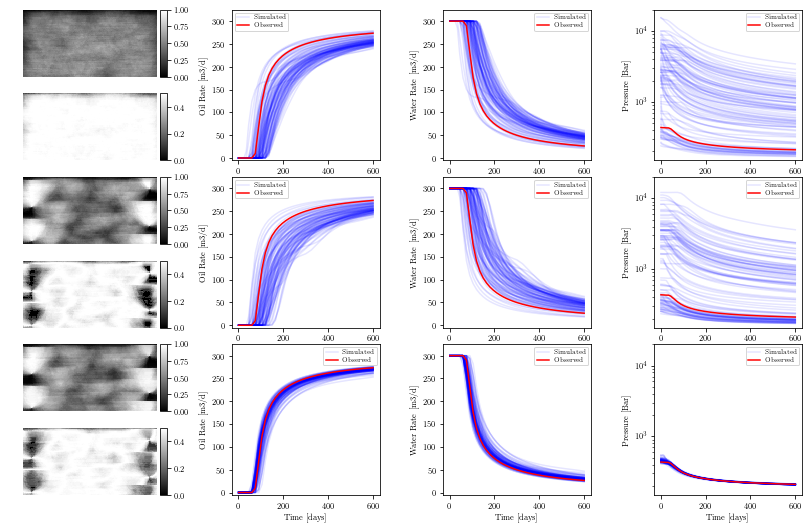

In [81]:
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=0.25)

def plot_rate_curves(axarr, min_curves, method="-Adam", color="blue", alpha=0.1, ref_color="red"):
    ref_curves = [qor_ref, qwr_ref, p_ref]


    for j, curves in enumerate(min_curves):
        if j == len(min_curves)-1:
            for k in range(3):
                axarr[k].plot(dts, curves[k], color=color, alpha=alpha, label="Simulated")       
        else:
            for k in range(3):
                axarr[k].plot(dts, curves[k], color=color, alpha=alpha)   
    
    for i, t  in zip(range(3), ["Oil Rate [m3/d]", "Water Rate [m3/d]", "Pressure [Bar]"]):
        axarr[i].plot(dts, ref_curves[i], color=ref_color, linestyle="-", label="Observed")
        axarr[i].set_ylabel(t)
        axarr[i].legend()

    for a in axarr:
        a.set_xlabel("Time [days]")
    
    axarr[0].set_ylim(-5, 325)
    axarr[1].set_ylim(-5, 325)
    axarr[2].set_yscale("log")
    axarr[2].set_ylim(150, 20000)

def plot_rate_bounds(axarr, min_curves, method="-Adam"):
    mean_curves, lower, upper = mean_confidence_interval(min_curves)
    #mean_curves = np.mean(min_curves, axis=0)
    #std_curves = np.std(min_curves, axis=0)
    ref_curves = [qor_ref, qwr_ref, p_ref]

    
    for i, t  in zip(range(3), ["Oil Rate [m3/d]", "Water Rate [m3/d]", "Pressure [Bar]"]):
        axarr[i].plot(dts, mean_curves[i], color="black", linestyle="-", label="Avg. Simulated")
        axarr[i].plot(dts, upper[i], color="black", linestyle="--")
        axarr[i].plot(dts, lower[i], color="black", linestyle="--")
        axarr[i].fill_between(dts, lower[i], upper[i], color="gray", alpha=0.5, label=r"Avg. $\pm \ \sigma$")

        #axarr[i].plot(dts, upper, color="black", linestyle="-.", linewidth=0.5)
        #axarr[i].plot(dts, lower, color="black", linestyle="-.", linewidth=0.5)
        #axarr[i].fill_between(dts, mean_curves[i]-2*std_curves[i], mean_curves[i]+2*std_curves[i], color="lightgray", alpha=0.5, label=r"Avg. $\pm \ 2\sigma$")
        
        axarr[i].plot(dts, ref_curves[i], color="red", linestyle="-", label="Observed")
        axarr[i].set_ylabel(t)
        axarr[i].legend()

    for a in axarr:
        a.set_xlabel("Time [days]")
        
def plot_facies(axarr, min_poroperms):
    x = np.where(min_poroperms[:, 1]>1e-13, 1, 0)
    mean = x.mean(axis=0)[::-1]
    std = x.std(axis=0)[::-1]
    sx1 = axarr[0].imshow(mean, vmin=0, vmax=1)
    axarr[0].set_axis_off()
    colorbar(sx1)
    sx2 = axarr[1].imshow(std, vmin=0, vmax=0.5)
    axarr[1].set_axis_off()
    colorbar(sx2)

def plot_row_envelopes(i, properties, curves):
    ax1 = plt.subplot2grid((8, 4*2), (i, 0), rowspan=1, colspan=2)
    ax2 = plt.subplot2grid((8, 4*2), (i+1, 0), rowspan=1, colspan=2)
    plot_facies([ax1, ax2], properties)
    
    ax3 = plt.subplot2grid((8, 4*2), (i, 2), rowspan=2, colspan=2)
    ax4 = plt.subplot2grid((8, 4*2), (i, 4), rowspan=2, colspan=2)
    ax5 = plt.subplot2grid((8, 4*2), (i, 6), rowspan=2, colspan=2)
    plot_rate_bounds([ax3, ax4, ax5], curves)
    
def plot_row_curves(i, properties, curves):
    ax1 = plt.subplot2grid((8, 4*2), (i, 0), rowspan=1, colspan=2)
    ax2 = plt.subplot2grid((8, 4*2), (i+1, 0), rowspan=1, colspan=2)
    plot_facies([ax1, ax2], properties)
    
    ax3 = plt.subplot2grid((8, 4*2), (i, 2), rowspan=2, colspan=2)
    ax4 = plt.subplot2grid((8, 4*2), (i, 4), rowspan=2, colspan=2)
    ax5 = plt.subplot2grid((8, 4*2), (i, 6), rowspan=2, colspan=2)
    plot_rate_curves([ax3, ax4, ax5], curves)
    
plot_row_curves(0, unc_props[0:100], unc_curves[0:100])
plot_row_curves(2, all_poroperms[1][0], all_curves[1][0])
plot_row_curves(4, all_poroperms[0][0], all_curves[0][0])

In [74]:
print(unc_curves.shape, all_poroperms[1][0].shape, unc_poros.shape)

(1000, 3, 37) (100, 2, 64, 128) (1000, 64, 128)


In [75]:
unc_props = np.concatenate([unc_poros.reshape(1000, 1, 64, 128), unc_perms.reshape(1000, 1, 64, 128)], 1)
print(unc_props.shape)

(1000, 2, 64, 128)


In [22]:
unc_curves, unc_poros, unc_perms = get_unconditionals('./results/runs/', perm)

99
199
299
399
499
599
699
799
899
999


In [30]:
def load_wells_only():
    curves = []
    for i in range(58):
        try:
            with xr.open_dataset('../runs/test_wells_6/iteration_'+str(i)+'.nc') as ds_ref:
                qor_ref = ds_ref['state_variables'][dict(state_variable=2, well=1)]*(-60*60*24)
                qwr_ref = ds_ref['state_variables'][dict(state_variable=1, well=1)]*(-60*60*24)
                p_ref = ds_ref['state_variables'][dict(state_variable=0, well=0)]/1e5
                curves.append([qor_ref, qwr_ref, p_ref])
        except FileNotFoundError:
            pass
    return curves

well_only = load_wells_only()

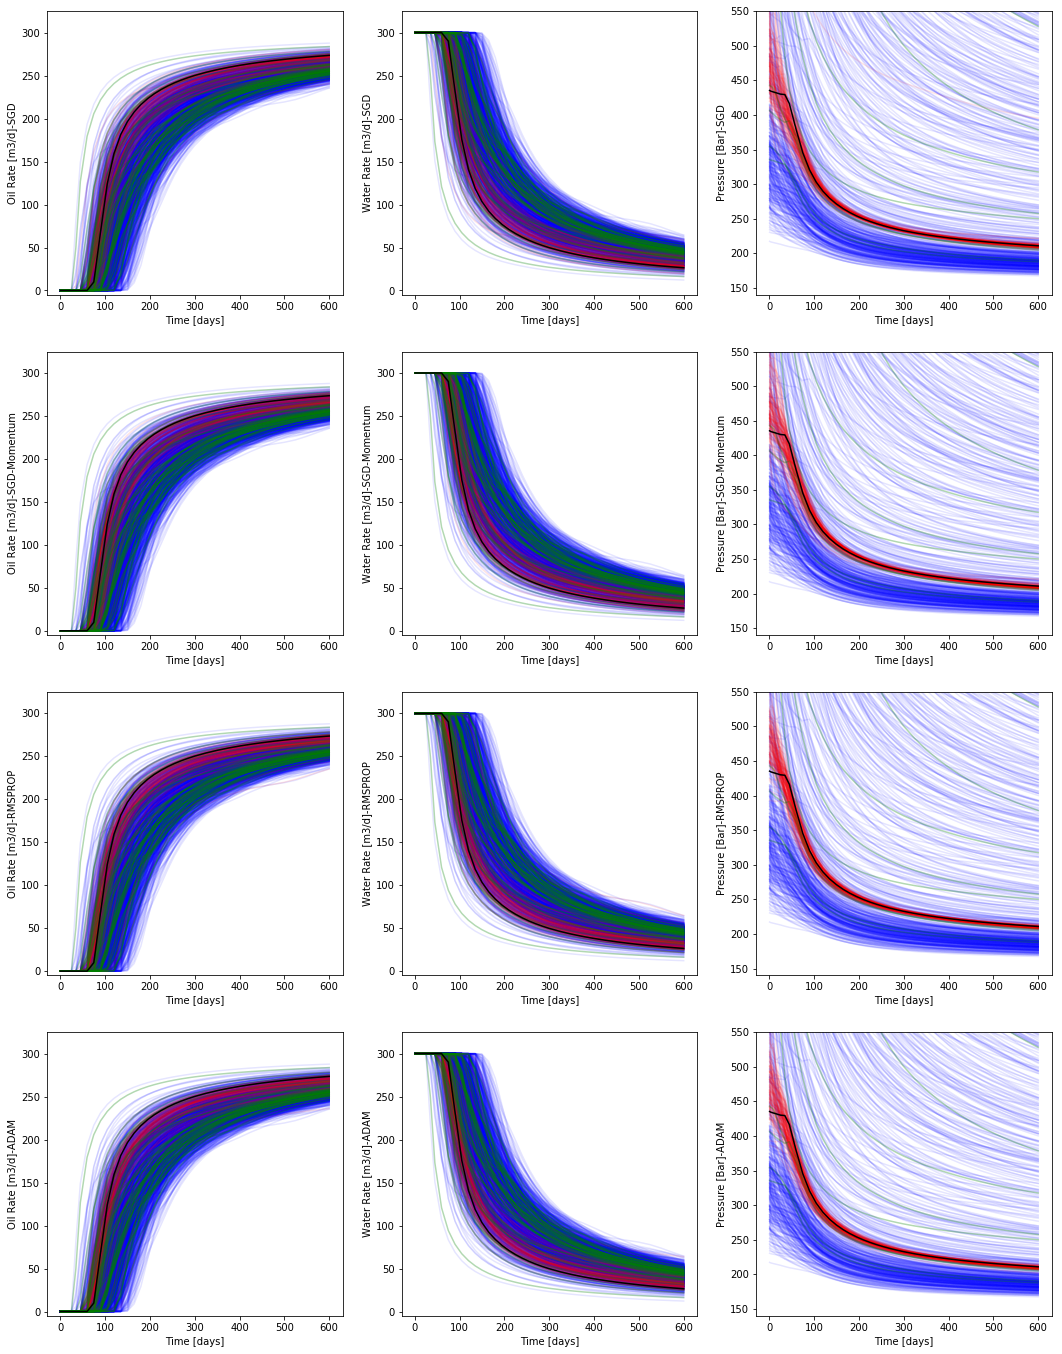

In [33]:
fig, axarr = plt.subplots(4, 3, figsize=(18, 6*4))
for ax, min_curves, method in zip(axarr, [x[3] for x in all_curves], ["-SGD", "-SGD-Momentum", "-RMSPROP", "-ADAM"]):
    mean_curves = np.mean(min_curves, axis=0)
    std_curves = np.std(min_curves, axis=0)
    ref_curves = [qor_ref, qwr_ref, p_ref]
    
    for j in range(3):
        for i, curves in enumerate(unconditionals):
            if i == 0:
                ax[j].plot(dts, curves[j], alpha=0.1, color="blue", linestyle="-", label="Prior")
            else:
                ax[j].plot(dts, curves[j], alpha=0.1, color="blue", linestyle="-")
        
    for i, curves in enumerate(min_curves):
        if i == len(min_curves)-1:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="red", alpha=0.1, label="Posterior")       
        else:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="red", alpha=0.1)   
    
    for i, curves in enumerate(well_only):
        if i == len(well_only)-1:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="green", alpha=0.3)       
        else:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="green", alpha=0.3) 
            
    for i, t  in zip(range(3), ["Oil Rate [m3/d]"+method, "Water Rate [m3/d]"+method, "Pressure [Bar]"+method]):
        ax[i].plot(dts, ref_curves[i], color="black", linestyle="-", label="Observed")
        ax[i].set_ylabel(t)
        #ax[i].legend()
    for a in ax:
        a.set_xlabel("Time [days]")

for ax in axarr[:, 0].flatten():
    ax.set_ylim(-5, 325)

for ax in axarr[:, 1].flatten():
    ax.set_ylim(-5, 325)
    
for ax in axarr[:, 2].flatten():
    ax.set_ylim(140, 550)
    
if plot:
    fig.savefig("./figures/"+perm+"_state_variables_prior_1000.png", dpi=300, bbox_inches="tight")

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(18, 6*1))
for ax, min_curves, method in zip([axarr], [x[3] for x in [all_curves[3]]], ["-ADAM"]):
    mean_curves = np.mean(min_curves, axis=0)
    std_curves = np.std(min_curves, axis=0)
    ref_curves = [qor_ref, qwr_ref, p_ref]

    for i, t  in zip(range(3), ["Oil Rate [m3/d]"+method, "Water Rate [m3/d]"+method, "Pressure [Bar]"+method]):
        ax[i].plot(dts, mean_curves[i], color="black", linestyle="-", label="Avg. Simulated")
        ax[i].plot(dts, mean_curves[i]+std_curves[i], color="black", linestyle="--")
        ax[i].plot(dts, mean_curves[i]-std_curves[i], color="black", linestyle="--")
        ax[i].fill_between(dts, mean_curves[i]-std_curves[i], mean_curves[i]+std_curves[i], color="gray", alpha=0.5, label=r"Avg. $\pm \ \sigma$")

        ax[i].plot(dts, ref_curves[i], color="red", linestyle="-", label="Observed")
        ax[i].set_ylabel(t)
        ax[i].legend()

    for a in ax:
        a.set_xlabel("Time [days]")

for ax, min_curves, method, c in zip([axarr, axarr], [well_only, unconditionals], ["-ADAM", "-ADAM"], ["blue", "green"]):
    mean_curves = np.mean(min_curves, axis=0)
    std_curves = np.std(min_curves, axis=0)
    ref_curves = [qor_ref, qwr_ref, p_ref]

    for i, t  in zip(range(3), ["Oil Rate [m3/d]"+method, "Water Rate [m3/d]"+method, "Pressure [Bar]"+method]):
        ax[i].plot(dts, mean_curves[i], color=c, linestyle="-")
        ax[i].plot(dts, mean_curves[i]+std_curves[i], color=c, linestyle="--")
        ax[i].plot(dts, mean_curves[i]-std_curves[i], color=c, linestyle="--")
        ax[i].fill_between(dts, mean_curves[i]-std_curves[i], mean_curves[i]+std_curves[i], color=c, alpha=0.1)
         

axarr[0].set_ylim(-5, 325)
axarr[1].set_ylim(-5, 325)
axarr[2].set_ylim(140, 550)
    
if plot:
    fig.savefig("./figures/"+perm+"_state_variables_bounds.png", dpi=300, bbox_inches="tight")

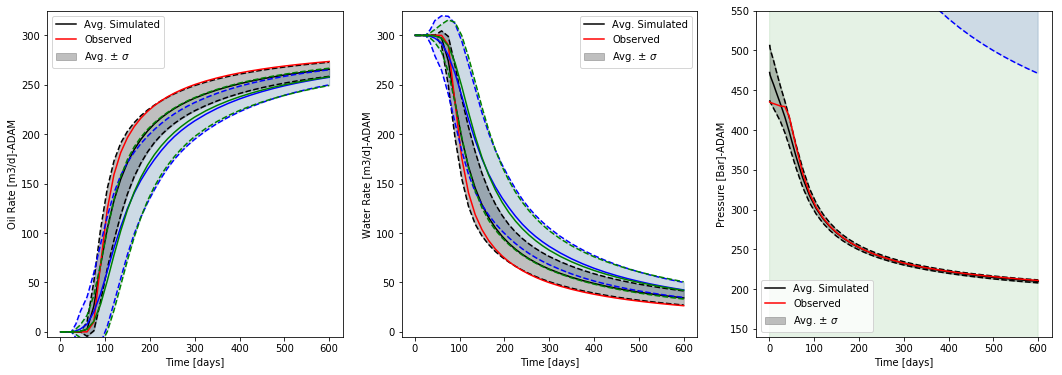

In [31]:
fig, axarr = plt.subplots(1, 3, figsize=(18, 6*1))
for ax, min_curves, method in zip([axarr], [x[3] for x in [all_curves[3]]], ["-ADAM"]):
    mean_curves = np.mean(min_curves, axis=0)
    std_curves = np.std(min_curves, axis=0)
    ref_curves = [qor_ref, qwr_ref, p_ref]

    for i, t  in zip(range(3), ["Oil Rate [m3/d]"+method, "Water Rate [m3/d]"+method, "Pressure [Bar]"+method]):
        ax[i].plot(dts, mean_curves[i], color="black", linestyle="-", label="Avg. Simulated")
        ax[i].plot(dts, mean_curves[i]+std_curves[i], color="black", linestyle="--")
        ax[i].plot(dts, mean_curves[i]-std_curves[i], color="black", linestyle="--")
        ax[i].fill_between(dts, mean_curves[i]-std_curves[i], mean_curves[i]+std_curves[i], color="gray", alpha=0.5, label=r"Avg. $\pm \ \sigma$")

        ax[i].plot(dts, ref_curves[i], color="red", linestyle="-", label="Observed")
        ax[i].set_ylabel(t)
        ax[i].legend()

    for a in ax:
        a.set_xlabel("Time [days]")

for ax, min_curves, method, c in zip([axarr, axarr], [well_only, unconditionals], ["-ADAM", "-ADAM"], ["blue", "green"]):
    mean_curves = np.mean(min_curves, axis=0)
    std_curves = np.std(min_curves, axis=0)
    ref_curves = [qor_ref, qwr_ref, p_ref]

    for i, t  in zip(range(3), ["Oil Rate [m3/d]"+method, "Water Rate [m3/d]"+method, "Pressure [Bar]"+method]):
        ax[i].plot(dts, mean_curves[i], color=c, linestyle="-")
        ax[i].plot(dts, mean_curves[i]+std_curves[i], color=c, linestyle="--")
        ax[i].plot(dts, mean_curves[i]-std_curves[i], color=c, linestyle="--")
        ax[i].fill_between(dts, mean_curves[i]-std_curves[i], mean_curves[i]+std_curves[i], color=c, alpha=0.1)
         

axarr[0].set_ylim(-5, 325)
axarr[1].set_ylim(-5, 325)
axarr[2].set_ylim(140, 550)
    
#if plot:
#fig.savefig("./figures/"+perm+"_state_variables_bounds.png", dpi=300, bbox_inches="tight")

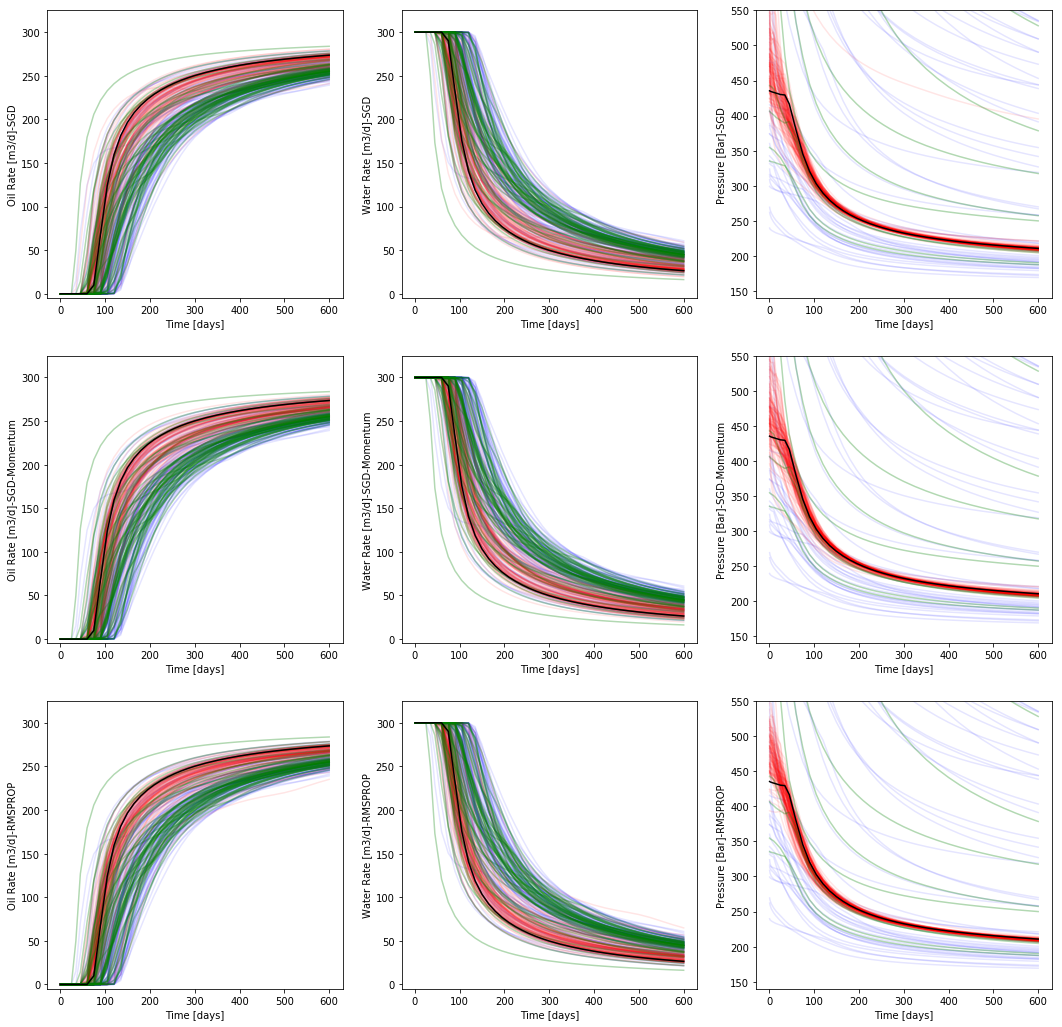

In [32]:
fig, axarr = plt.subplots(3, 3, figsize=(18, 6*3))
for ax, min_curves, method_desc, method in zip(axarr, [x[3] for x in all_curves], ["-SGD", "-SGD-Momentum", "-RMSPROP", "-ADAM"], ["sgd", "sgdmomentum", "rmsprop", "adam"]):
    mean_curves = np.mean(min_curves, axis=0)
    std_curves = np.std(min_curves, axis=0)
    ref_curves = [qor_ref, qwr_ref, p_ref]
    
    misfits = np.load("./misfits/"+perm+"/misfits_low_"+method+"_1_e_1.npy")
    min_f = extract_min_misfits(misfits, 3)
    
    for j in range(3):
        for i, run in enumerate(min_f):
            curves = unconditionals[int(run[0])]
            if i == 0:
                ax[j].plot(dts, curves[j], alpha=0.1, color="blue", linestyle="-", label="Prior")
            else:
                ax[j].plot(dts, curves[j], alpha=0.1, color="blue", linestyle="-")
        
    for i, curves in enumerate(min_curves):
        if i == len(min_curves)-1:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="red", alpha=0.1, label="Posterior")       
        else:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="red", alpha=0.1) 
    
    for i, curves in enumerate(well_only):
        if i == len(well_only)-1:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="green", alpha=0.3)       
        else:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="green", alpha=0.3) 
            
    for i, t  in zip(range(3), ["Oil Rate [m3/d]"+method_desc, "Water Rate [m3/d]"+method_desc, "Pressure [Bar]"+method_desc]):
        ax[i].plot(dts, ref_curves[i], color="black", linestyle="-", label="Observed")
        ax[i].set_ylabel(t)
        #ax[i].legend()
    for a in ax:
        a.set_xlabel("Time [days]")

for ax in axarr[:, 0].flatten():
    ax.set_ylim(-5, 325)

for ax in axarr[:, 1].flatten():
    ax.set_ylim(-5, 325)


for ax in axarr[:, 0].flatten():
    ax.set_ylim(-5, 325)

for ax in axarr[:, 1].flatten():
    ax.set_ylim(-5, 325)
    
for ax in axarr[:, 2].flatten():
    ax.set_ylim(140, 550)

if plot:
    fig.savefig("./figures/"+perm+"_state_variables_prior_simulated.png", dpi=300, bbox_inches="tight")

In [11]:
def collect_poro_perm(mins, run, prop="min_f"):
    poros, perms = [], []
    for num in mins:
        folder = './runs/'+run+'/'+prop+'/run_'+str(int(num[0]))
        ds = xr.open_dataset(folder+'/iteration_'+str(int(num[1]))+'.nc')
        poros.append(ds['material_properties'][0].values)
        perms.append(ds['material_properties'][1].values)
        ds.close()
    return np.array(poros), np.array(perms)

def extract_min_misfits(misfits, pos):
    mins = np.array([(i, np.argmin(x[:, pos], axis=0), x[np.argmin(x[:, pos], axis=0), pos]) for i, x in enumerate(misfits) if len(x) != 0])
    return mins

def get_min_misfits_for_each_folder(folders):
    misfits = []
    for folder, misfit_file in zip(folders, ["misfits_low_sgd_1_e_1.npy", "misfits_low_sgdmomentum_1_e_1.npy",  "misfits_low_rmsprop_1_e_1.npy", "misfits_low_adam_1_e_1.npy"]):
        misfits.append(np.load("./misfits/"+perm+"/"+misfit_file))
    
    min_fs = [extract_min_misfits(misfit, 3) for misfit in misfits]
    poro_perms = [collect_poro_perm(min_f, folder) for folder, min_f in zip(folders, min_fs)]
    return poro_perms

poro_perms = get_min_misfits_for_each_folder(folders)

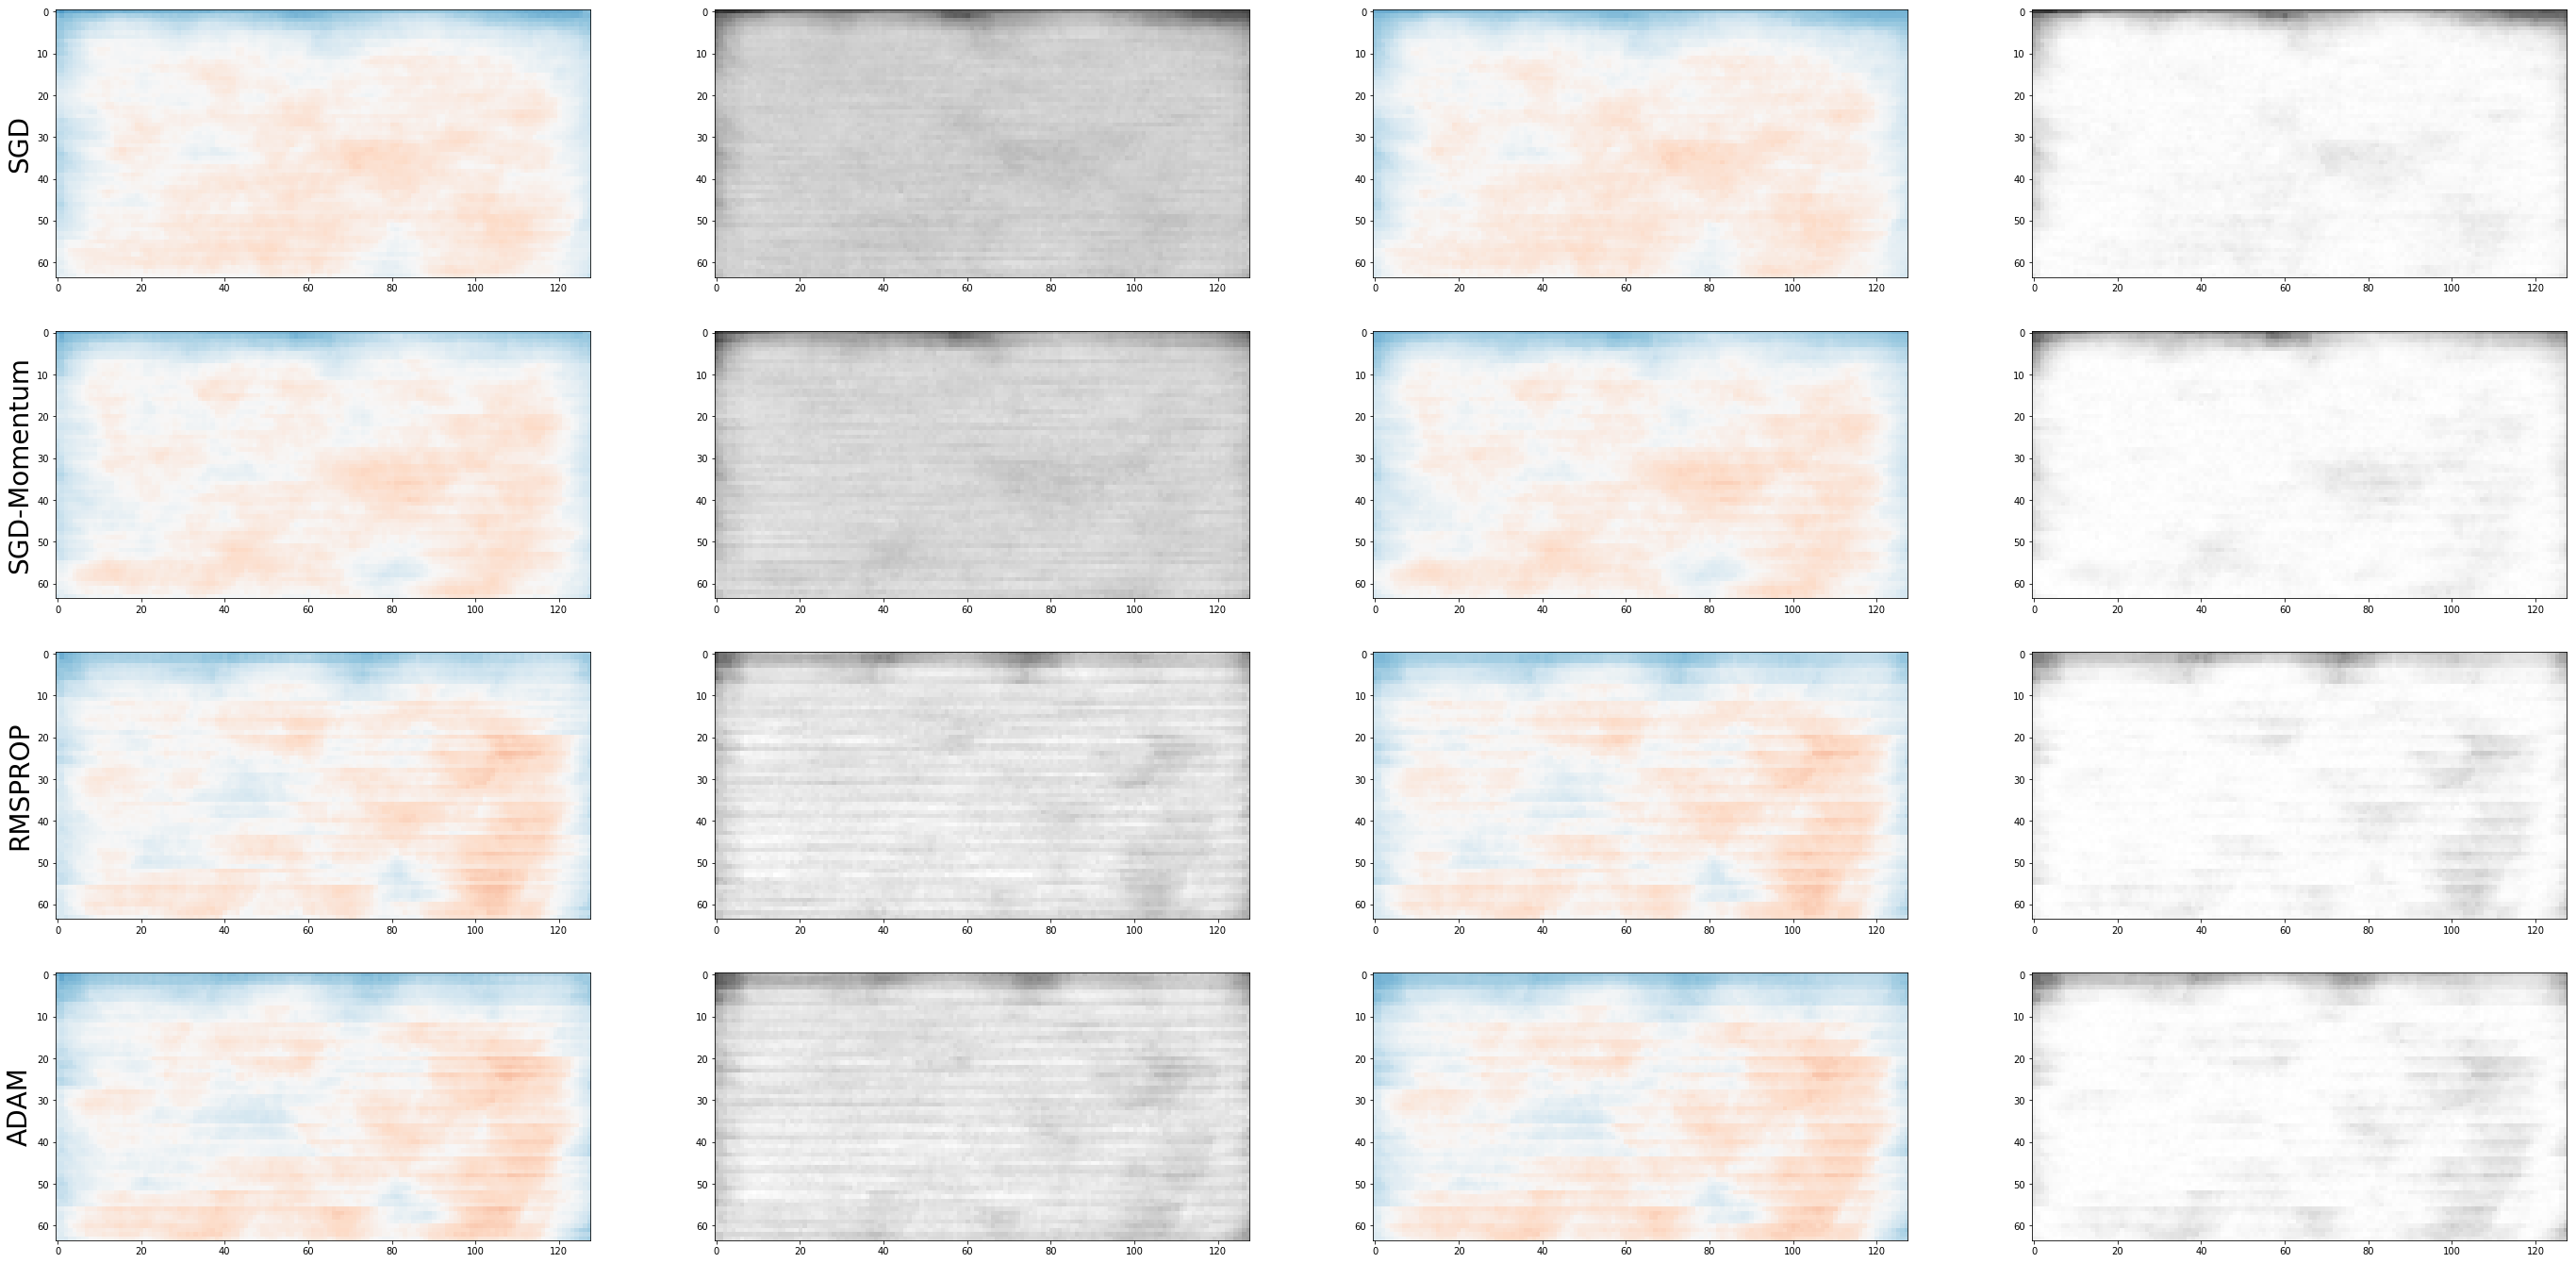

In [12]:
fig, axarr = plt.subplots(4, 4, figsize=(6*2*4, 4*6))
for ax, poro_perm, method in zip(axarr, poro_perms, ["SGD", "SGD-Momentum", "RMSPROP", "ADAM"]):
    
    mean_poro = np.mean(poro_perm[0], axis=0)
    std_poro = np.std(poro_perm[0], axis=0)
    mean_poro_all = np.mean(poro_perm[0].flatten())
    std_poro_all = np.std(poro_perm[0].flatten())
    mean_poro -= mean_poro_all
    mean_poro /= std_poro_all
    
    ax[0].imshow(mean_poro, vmin=-2, vmax=2, cmap="RdBu_r")
    ax[1].imshow(std_poro, vmin=0, vmax=0.12, cmap="gray")
    
    mean_perm = np.mean(poro_perm[1], axis=0)
    std_perm = np.std(poro_perm[1], axis=0)
    mean_perm_all = np.mean(poro_perm[1].flatten())
    std_perm_all = np.std(poro_perm[1].flatten())
    mean_perm -= mean_perm_all
    mean_perm /= std_perm_all
    
    ax[2].imshow(mean_perm, vmin=-2, vmax=2, cmap="RdBu_r")
    ax[3].imshow(std_perm, vmin=0, vmax=5e-13, cmap="gray")
    ax[0].set_ylabel(method, fontsize=28)

    
if plot:
    fig.savefig("./figures/"+perm+"_poro_perm_overview.png", dpi=300, bbox_inches="tight")

4.951323e-13
0.108929485


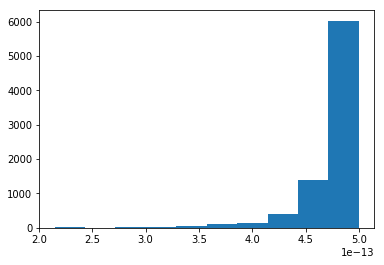

In [13]:
plt.hist(std_perm.flatten())
print(std_perm_all)
print(std_poro_all)

(array([4.000e+00, 1.000e+01, 1.100e+01, 3.500e+01, 7.000e+01, 1.820e+02,
        4.100e+02, 1.855e+03, 4.909e+03, 7.060e+02]),
 array([0.03764082, 0.04588734, 0.05413387, 0.06238039, 0.07062691,
        0.07887344, 0.08711996, 0.09536649, 0.10361301, 0.11185953,
        0.12010606], dtype=float32),
 <a list of 10 Patch objects>)

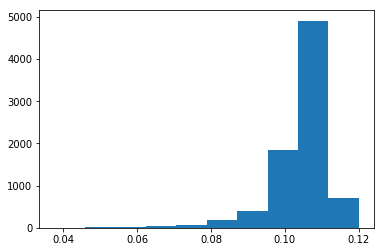

In [14]:
plt.hist(std_poro.flatten())

In [18]:
gt = np.load("../model_67_x.npy")

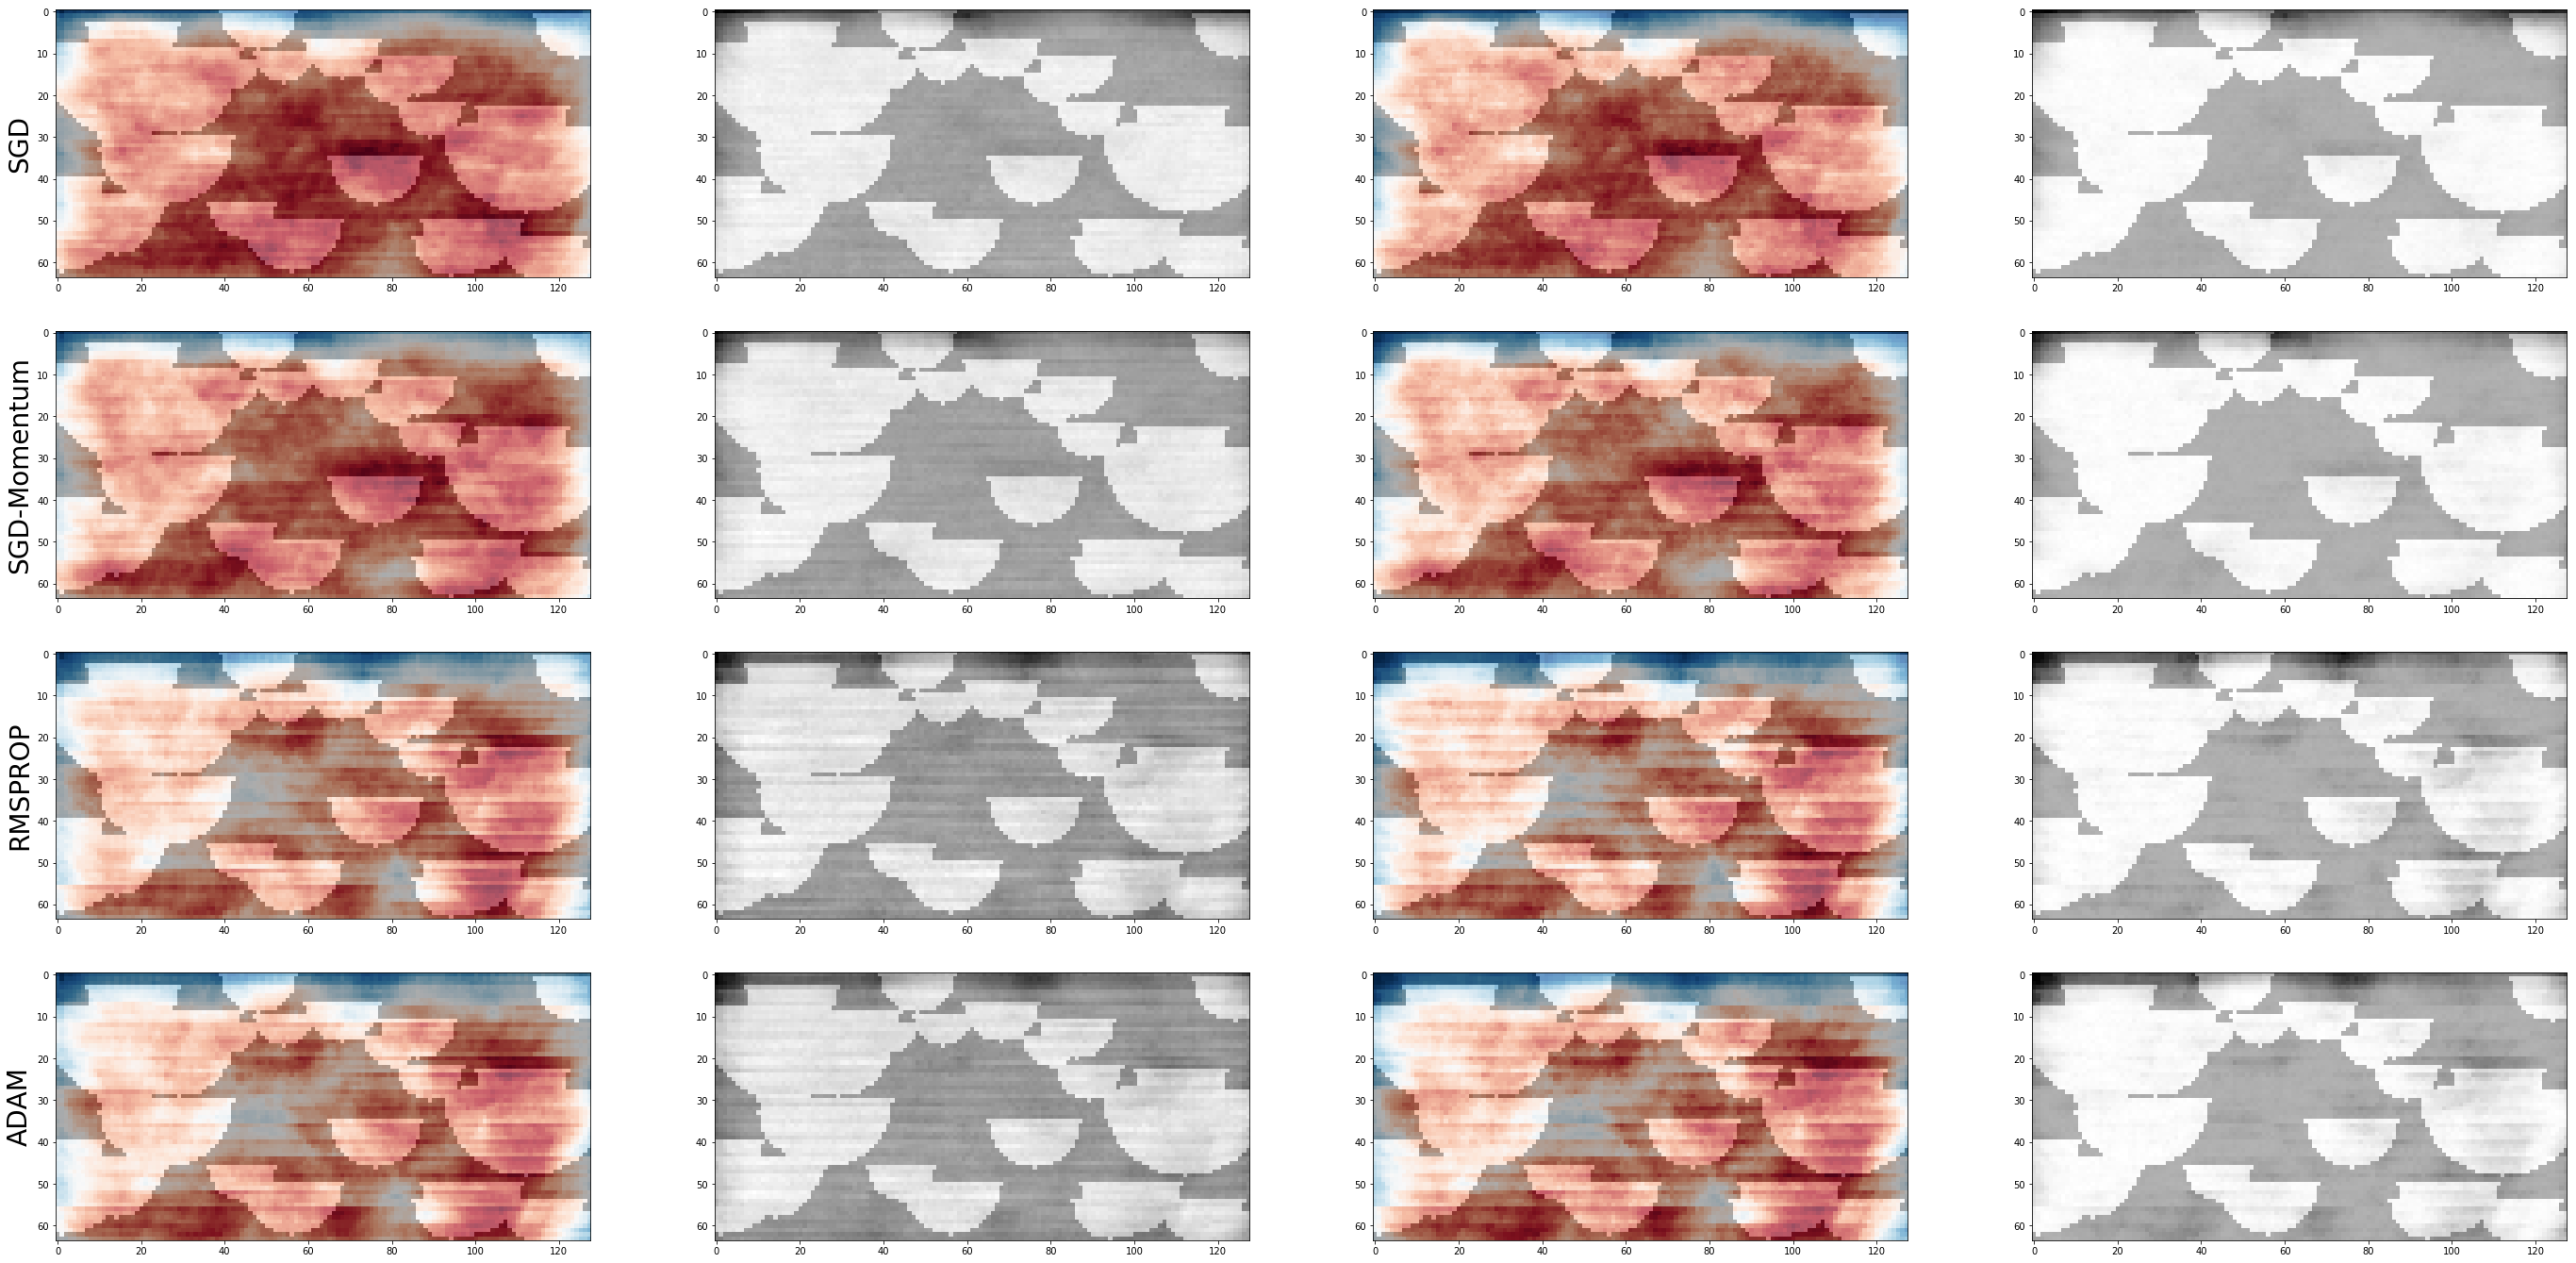

In [25]:
fig, axarr = plt.subplots(4, 4, figsize=(6*2*4, 4*6))
for ax, poro_perm, method in zip(axarr, poro_perms, ["SGD", "SGD-Momentum", "RMSPROP", "ADAM"]):
    
    mean_poro = np.mean(poro_perm[0], axis=0)
    std_poro = np.std(poro_perm[0], axis=0)
    
    ax[0].imshow(mean_poro, cmap="RdBu_r")
    ax[1].imshow(std_poro, cmap="gray")
    
    mean_perm = np.mean(poro_perm[1], axis=0)
    std_perm = np.std(poro_perm[1], axis=0)
    
    ax[2].imshow(mean_perm, cmap="RdBu_r")
    ax[3].imshow(std_perm, cmap="gray")
    ax[0].set_ylabel(method, fontsize=28)
    
    for a in ax:
        a.imshow(gt[0].T, cmap="gray", alpha=0.3)

    
if plot:
    fig.savefig("./figures/"+perm+"_poro_perm_overview.png", dpi=300, bbox_inches="tight")

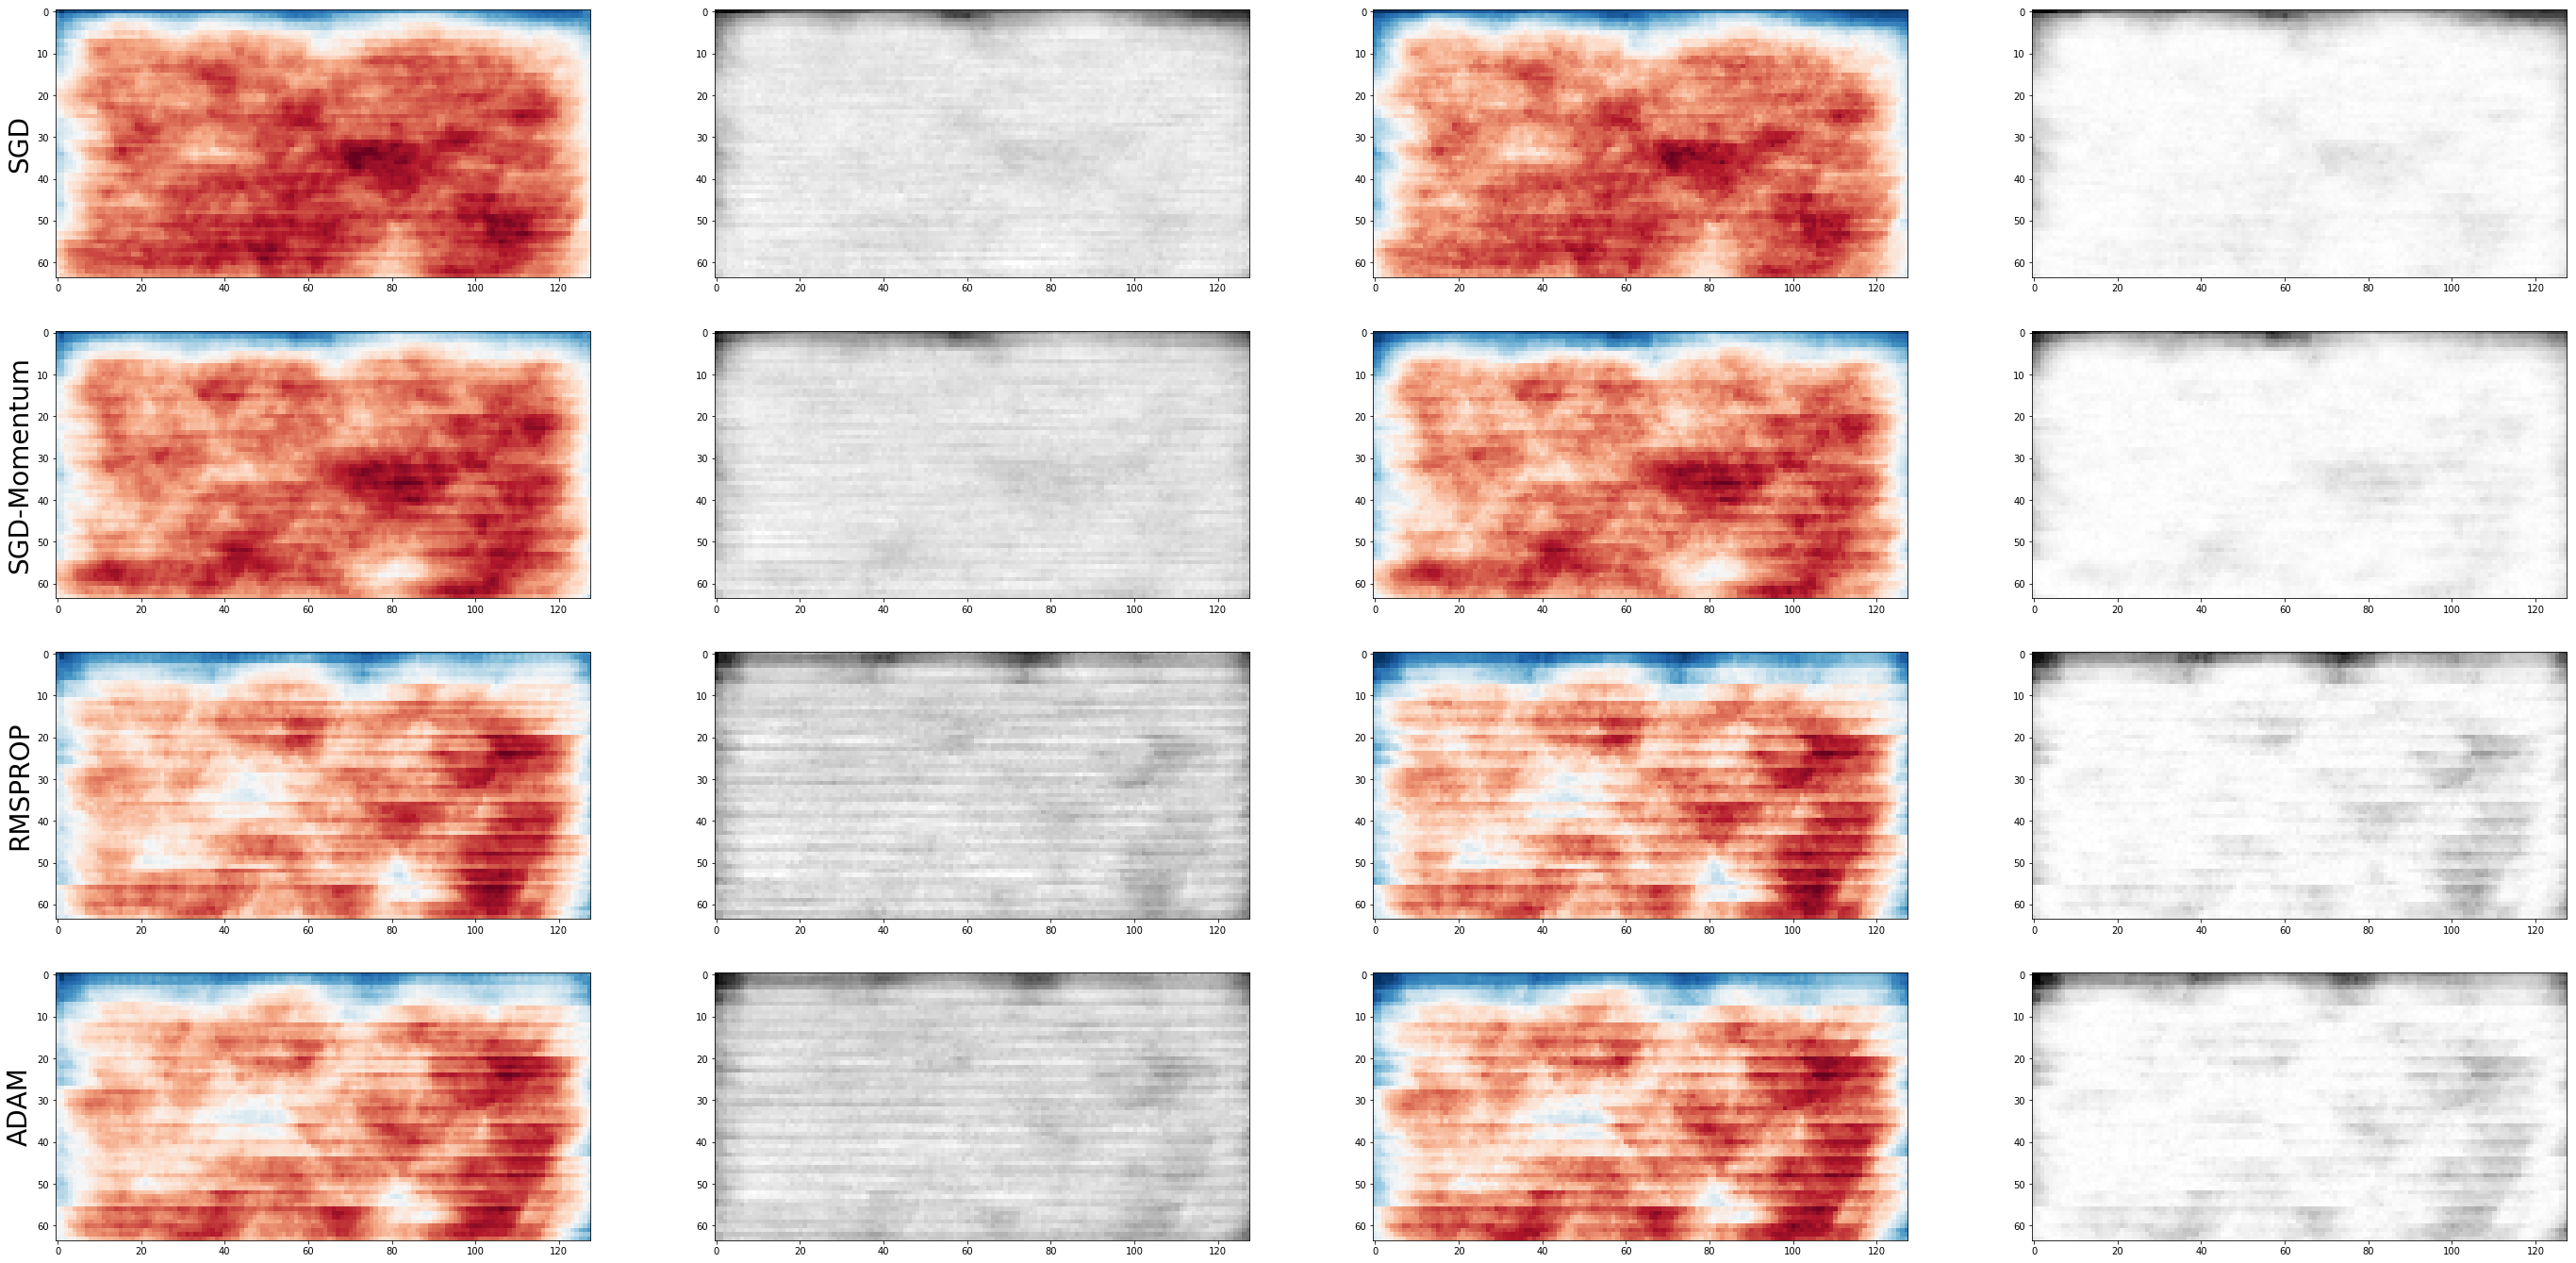

In [24]:
fig, axarr = plt.subplots(4, 4, figsize=(6*2*4, 4*6))
for ax, poro_perm, method in zip(axarr, poro_perms, ["SGD", "SGD-Momentum", "RMSPROP", "ADAM"]):
    
    mean_poro = np.mean(poro_perm[0], axis=0)
    std_poro = np.std(poro_perm[0], axis=0)
    
    ax[0].imshow(mean_poro, cmap="RdBu_r")
    ax[1].imshow(std_poro, cmap="gray")
    
    mean_perm = np.mean(poro_perm[1], axis=0)
    std_perm = np.std(poro_perm[1], axis=0)
    
    ax[2].imshow(mean_perm, cmap="RdBu_r")
    ax[3].imshow(std_perm, cmap="gray")
    ax[0].set_ylabel(method, fontsize=28)
    
if plot:
    fig.savefig("./figures/"+perm+"_poro_perm_overview.png", dpi=300, bbox_inches="tight")

4
4


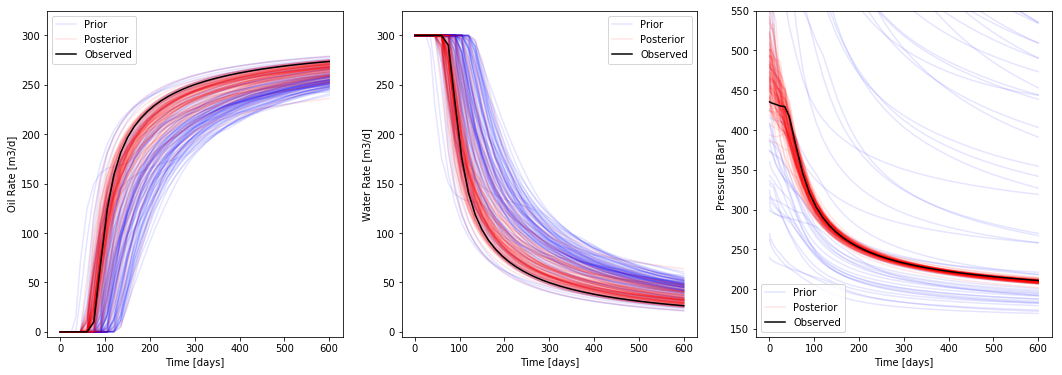

In [35]:
fig, axarr = plt.subplots(1, 3, figsize=(18, 6*1))
axarr = np.array([axarr])
print(len(all_curves))
dat =  [x[3] for x in all_curves]
print(len(dat))
for ax, min_curves, method_desc, method in zip(axarr, [dat[3]], [""], ["adam"]):
    mean_curves = np.mean(min_curves, axis=0)
    std_curves = np.std(min_curves, axis=0)
    ref_curves = [qor_ref, qwr_ref, p_ref]
    
    misfits = np.load("./misfits/"+perm+"/misfits_low_"+method+"_1_e_1.npy")
    min_f = extract_min_misfits(misfits, 3)
    
    for j in range(3):
        for i, run in enumerate(min_f):
            curves = unconditionals[int(run[0])]
            if i == 0:
                ax[j].plot(dts, curves[j], alpha=0.1, color="blue", linestyle="-", label="Prior")
            else:
                ax[j].plot(dts, curves[j], alpha=0.1, color="blue", linestyle="-")
        
    for i, curves in enumerate(min_curves):
        if i == len(min_curves)-1:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="red", alpha=0.1, label="Posterior")       
        else:
            for i in range(3):
                ax[i].plot(dts, curves[i], color="red", alpha=0.1)    
            
    for i, t  in zip(range(3), ["Oil Rate [m3/d]"+method_desc, "Water Rate [m3/d]"+method_desc, "Pressure [Bar]"+method_desc]):
        ax[i].plot(dts, ref_curves[i], color="black", linestyle="-", label="Observed")
        ax[i].set_ylabel(t)
        ax[i].legend()
    for a in ax:
        a.set_xlabel("Time [days]")

for ax in axarr[:, 0].flatten():
    ax.set_ylim(-5, 325)

for ax in axarr[:, 1].flatten():
    ax.set_ylim(-5, 325)


for ax in axarr[:, 0].flatten():
    ax.set_ylim(-5, 325)

for ax in axarr[:, 1].flatten():
    ax.set_ylim(-5, 325)
    
for ax in axarr[:, 2].flatten():
    ax.set_ylim(140, 550)

#if plot:
fig.savefig("./figures/"+perm+"_state_variables_prior_simulated_adam_only.png", dpi=300, bbox_inches="tight")